In [1]:
print("hello world")

hello world


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from cancer_pattern_mining import (
    SequenceTransformer, 
    SequencePatternMiner,
    analyze_sequences
)


#### Load Dataset

In [3]:
df = pd.read_csv('../RawData/cancer_data.csv')
print(f"Dataset shape: {df.shape}")
print(f"\nDiagnosis distribution:")
print(df['diagnosis'].value_counts())
df.head()

Dataset shape: (569, 33)

Diagnosis distribution:
diagnosis
B    357
M    212
Name: count, dtype: int64


,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [4]:
# Transform to sequences
print("Transforming features to sequences...")
transformer = SequenceTransformer(top_k=5, max_length=3, max_gap=1)
sequences = transformer.fit_transform(df)
print(f"Created {len(sequences)} sequences")

# Show example sequences
print("\n" + "=" * 80)
print("Example Sequences:")
print("=" * 80)
for i, seq in enumerate(sequences[:5]):
    # Updated for new sequence format: each sequence has one itemset containing multiple features
    if len(seq['sequence']) == 1 and isinstance(seq['sequence'][0], list):
        itemset = seq['sequence'][0]
        seq_str = '{' + ', '.join(itemset) + '}'
    else:
        seq_str = ' → '.join(['{' + ', '.join(itemset) + '}' for itemset in seq['sequence']])
    
    print(f"\nPatient {seq['id']} [{seq['diagnosis']}]:")
    print(f"  Sequence: {seq_str}")
    print(f"  Top features: {', '.join(seq['top_features'][:3])}")

Transforming features to sequences...
Created 569 sequences

Example Sequences:

Patient 842302 [M]:
  Sequence: {compactness_mean, perimeter_se, symmetry_worst, concavity_mean, compactness_worst}
  Top features: compactness_mean, perimeter_se, symmetry_worst

Patient 842517 [M]:
  Sequence: {area_mean, area_worst, radius_mean, radius_worst, perimeter_mean}
  Top features: area_mean, area_worst, radius_mean

Patient 84300903 [M]:
  Sequence: {concave points_mean, concave points_worst, radius_mean, perimeter_mean, area_mean}
  Top features: concave points_mean, concave points_worst, radius_mean

Patient 84348301 [M]:
  Sequence: {symmetry_worst, fractal_dimension_worst, fractal_dimension_mean, symmetry_se, compactness_worst}
  Top features: symmetry_worst, fractal_dimension_worst, fractal_dimension_mean

Patient 84358402 [M]:
  Sequence: {area_mean, perimeter_mean, radius_mean, smoothness_se, texture_worst}
  Top features: area_mean, perimeter_mean, radius_mean


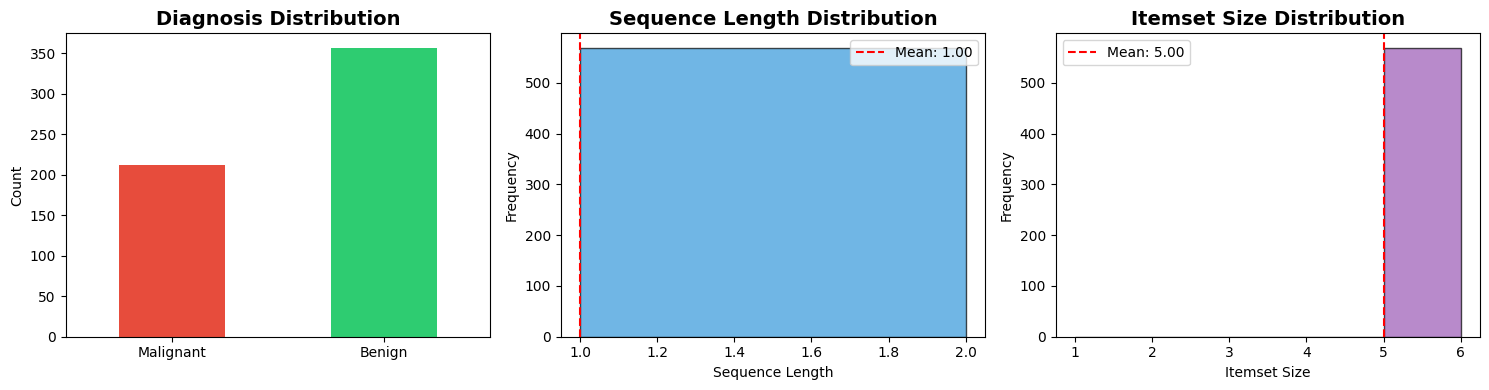


Sequence Statistics:
total_sequences......................... 569
malignant_count......................... 212
benign_count............................ 357
avg_sequence_length..................... 1.00
avg_itemset_size........................ 5.00


In [5]:
# Analyze sequence statistics
stats = analyze_sequences(sequences)

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Diagnosis distribution
diagnosis_counts = pd.Series({
    'Malignant': stats['malignant_count'],
    'Benign': stats['benign_count']
})
diagnosis_counts.plot(kind='bar', ax=axes[0], color=['#e74c3c', '#2ecc71'])
axes[0].set_title('Diagnosis Distribution', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Count')
axes[0].set_xticklabels(['Malignant', 'Benign'], rotation=0)

# Sequence length distribution
seq_lengths = [len(s['sequence']) for s in sequences]
axes[1].hist(seq_lengths, bins=range(1, max(seq_lengths)+2), 
             color='#3498db', edgecolor='black', alpha=0.7)
axes[1].set_title('Sequence Length Distribution', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Sequence Length')
axes[1].set_ylabel('Frequency')
axes[1].axvline(np.mean(seq_lengths), color='red', linestyle='--', 
                label=f'Mean: {np.mean(seq_lengths):.2f}')
axes[1].legend()

# Itemset size distribution
itemset_sizes = [len(item) for s in sequences for item in s['sequence']]
axes[2].hist(itemset_sizes, bins=range(1, max(itemset_sizes)+2), 
             color='#9b59b6', edgecolor='black', alpha=0.7)
axes[2].set_title('Itemset Size Distribution', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Itemset Size')
axes[2].set_ylabel('Frequency')
axes[2].axvline(np.mean(itemset_sizes), color='red', linestyle='--',
                label=f'Mean: {np.mean(itemset_sizes):.2f}')
axes[2].legend()

plt.tight_layout()
plt.show()

print("\nSequence Statistics:")
print("=" * 50)
for key, value in stats.items():
    print(f"{key:.<40} {value:.2f}" if isinstance(value, float) else f"{key:.<40} {value}")

In [6]:
# Mine patterns with different support thresholds
print("Mining patterns...\n")
# ADD max_pattern_length parameter since we're now mining subsets
miner = SequencePatternMiner(min_support=0.2, max_pattern_length=3)
patterns = miner.mine_patterns(sequences)

print(f"Found {len(patterns)} frequent patterns")

if len(patterns) > 0:
    print(f"Malignant-discriminative: {len(patterns[patterns['discriminates'] == 'Malignant'])}")
    print(f"Benign-discriminative: {len(patterns[patterns['discriminates'] == 'Benign'])}")
    print(f"Neutral: {len(patterns[patterns['discriminates'] == 'Neutral'])}")
else:
    print("No patterns found. Try lowering min_support")

Mining patterns...

Processing 212 malignant and 357 benign sequences
Found 1423 unique patterns in malignant, 1713 in benign
Successfully mined 17 patterns meeting support threshold
Found 17 frequent patterns
Malignant-discriminative: 5
Benign-discriminative: 9
Neutral: 3


In [7]:
# Display top patterns
print("\n" + "=" * 100)
print("TOP 20 DISCRIMINATIVE PATTERNS")
print("=" * 100)

if len(patterns) > 0:
    top_patterns = patterns.head(20)
    display_df = top_patterns[['pattern_str', 'length', 'malignant_support', 
                               'benign_support', 'lift', 'discriminates']].copy()
    display_df.columns = ['Pattern', 'Len', 'M_Supp', 'B_Supp', 'Lift', 'Discriminates']
    display_df['M_Supp'] = display_df['M_Supp'].round(3)
    display_df['B_Supp'] = display_df['B_Supp'].round(3)
    display_df['Lift'] = display_df['Lift'].round(3)
    display(display_df)
else:
    print("No patterns to display. Lower the min_support threshold.")


TOP 20 DISCRIMINATIVE PATTERNS


,Pattern,Len,M_Supp,B_Supp,Lift,Discriminates
0,{area_mean},1,0.222,0.020,11.306,Malignant
1,{radius_worst},1,0.241,0.087,2.770,Malignant
2,{texture_se},1,0.123,0.333,0.368,Benign
3,{concave points_se},1,0.108,0.244,0.445,Benign
4,{smoothness_mean},1,0.151,0.331,0.457,Benign
5,{smoothness_se},1,0.118,0.246,0.478,Benign
6,{texture_mean},1,0.170,0.328,0.518,Benign
7,"{texture_mean, texture_worst}",2,0.137,0.252,0.543,Benign
8,{compactness_worst},1,0.208,0.115,1.807,Malignant
9,{symmetry_mean},1,0.156,0.280,0.556,Benign


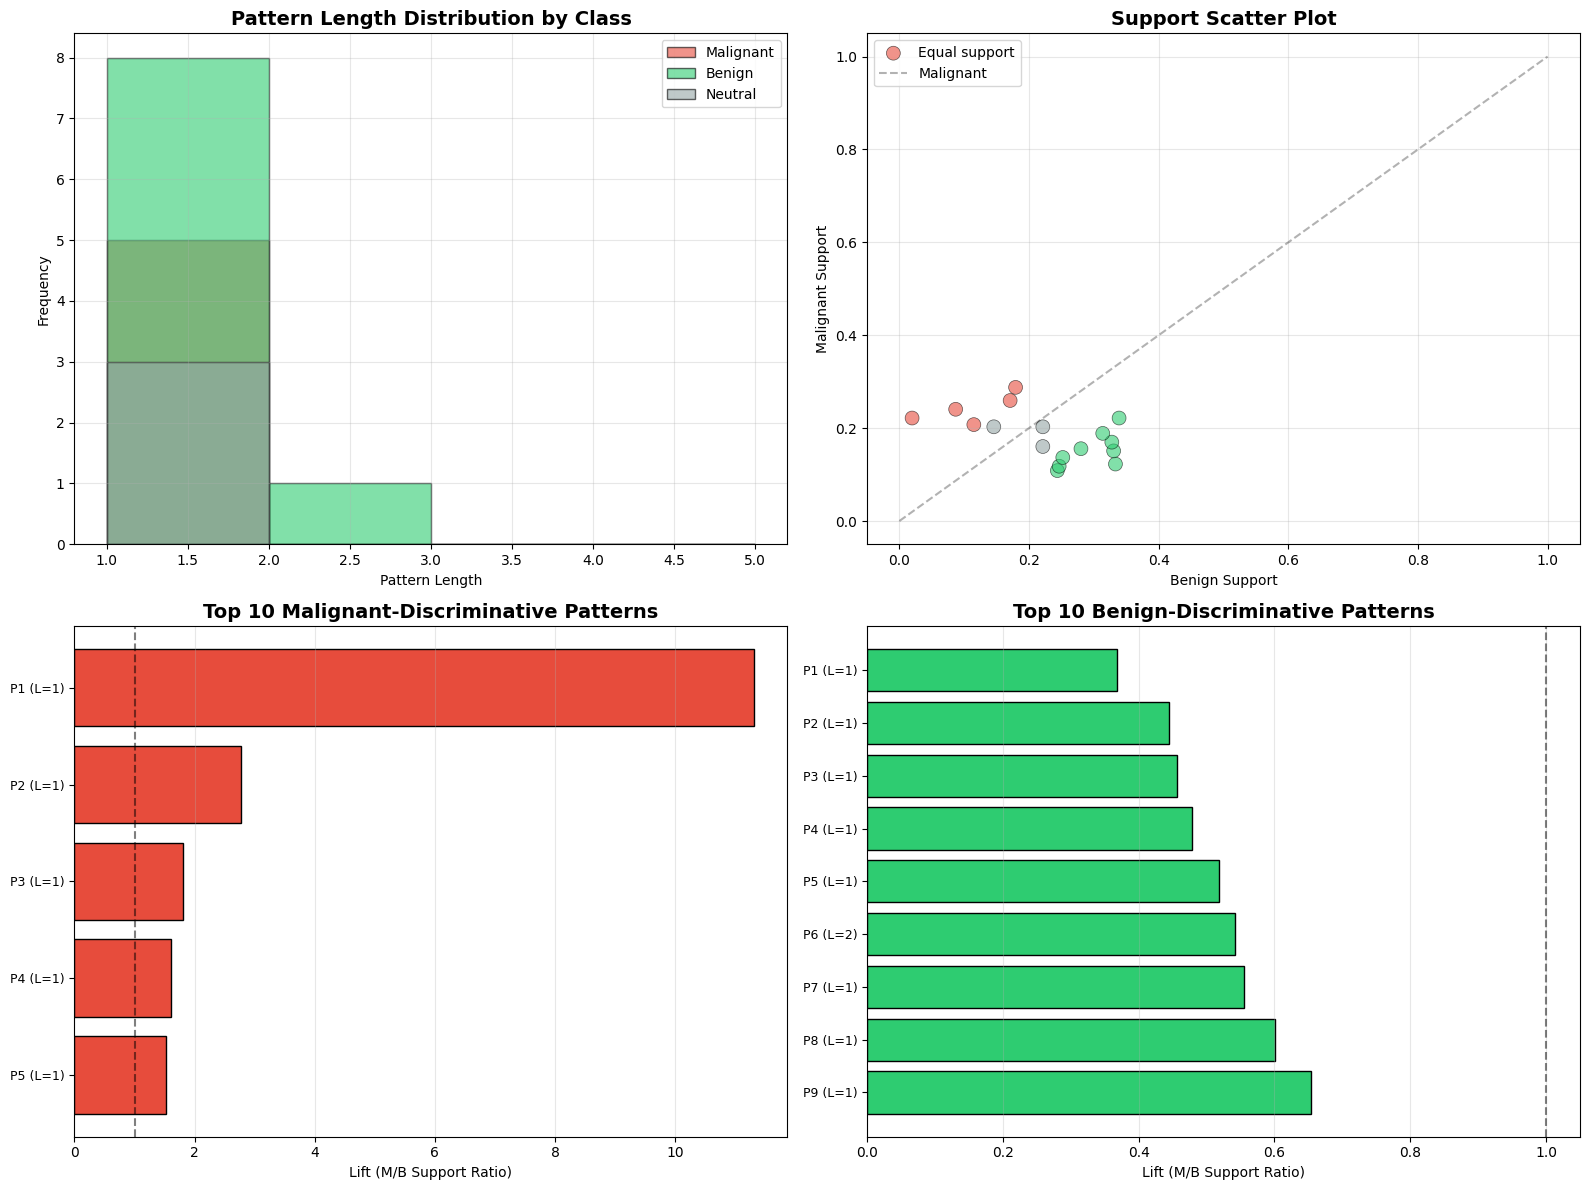

In [8]:
if len(patterns) == 0:
    print("⚠️ No patterns found. Skipping visualizations.")
    print("Try lowering min_support to 0.2 or 0.1")
else:
    # Visualization 1: Pattern length vs discriminative power
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Pattern length distribution by class
for disc_class, color in [('Malignant', '#e74c3c'), ('Benign', '#2ecc71'), ('Neutral', '#95a5a6')]:
    subset = patterns[patterns['discriminates'] == disc_class]
    axes[0, 0].hist(subset['length'], bins=range(1, 6), alpha=0.6, 
                    label=disc_class, color=color, edgecolor='black')
axes[0, 0].set_title('Pattern Length Distribution by Class', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Pattern Length')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# 2. Support scatter plot
colors = patterns['discriminates'].map({
    'Malignant': '#e74c3c',
    'Benign': '#2ecc71',
    'Neutral': '#95a5a6'
})
axes[0, 1].scatter(patterns['benign_support'], patterns['malignant_support'], 
                   c=colors, alpha=0.6, s=100, edgecolors='black', linewidth=0.5)
axes[0, 1].plot([0, 1], [0, 1], 'k--', alpha=0.3, label='Equal support')
axes[0, 1].set_title('Support Scatter Plot', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Benign Support')
axes[0, 1].set_ylabel('Malignant Support')
axes[0, 1].legend(['Equal support', 'Malignant', 'Benign', 'Neutral'])
axes[0, 1].grid(alpha=0.3)

# 3. Top discriminative patterns for Malignant
top_malignant = patterns[patterns['discriminates'] == 'Malignant'].head(10)
y_pos = np.arange(len(top_malignant))
axes[1, 0].barh(y_pos, top_malignant['lift'], color='#e74c3c', edgecolor='black')
axes[1, 0].set_yticks(y_pos)
axes[1, 0].set_yticklabels([f"P{i+1} (L={l})" for i, l in enumerate(top_malignant['length'])], 
                           fontsize=9)
axes[1, 0].set_xlabel('Lift (M/B Support Ratio)')
axes[1, 0].set_title('Top 10 Malignant-Discriminative Patterns', 
                     fontsize=14, fontweight='bold')
axes[1, 0].axvline(1, color='black', linestyle='--', alpha=0.5)
axes[1, 0].grid(alpha=0.3, axis='x')
axes[1, 0].invert_yaxis()

# 4. Top discriminative patterns for Benign
top_benign = patterns[patterns['discriminates'] == 'Benign'].head(10)
y_pos = np.arange(len(top_benign))
axes[1, 1].barh(y_pos, top_benign['lift'], color='#2ecc71', edgecolor='black')
axes[1, 1].set_yticks(y_pos)
axes[1, 1].set_yticklabels([f"P{i+1} (L={l})" for i, l in enumerate(top_benign['length'])], 
                           fontsize=9)
axes[1, 1].set_xlabel('Lift (M/B Support Ratio)')
axes[1, 1].set_title('Top 10 Benign-Discriminative Patterns', 
                     fontsize=14, fontweight='bold')
axes[1, 1].axvline(1, color='black', linestyle='--', alpha=0.5)
axes[1, 1].grid(alpha=0.3, axis='x')
axes[1, 1].invert_yaxis()

plt.tight_layout()
plt.show()

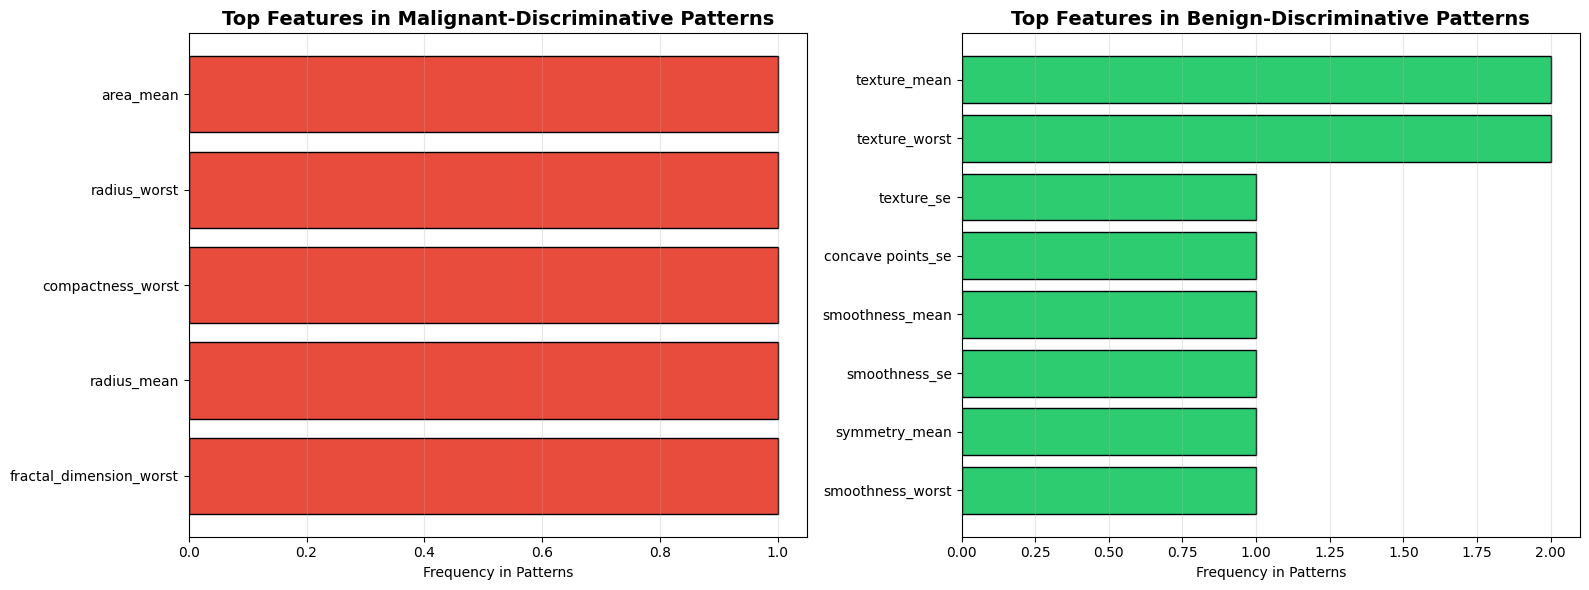

In [9]:
# Visualization 2: Feature frequency in patterns
from collections import Counter

# Extract all features from patterns - UPDATED FOR NEW FORMAT
def extract_features_from_patterns(patterns_df, discriminates=None):
    if discriminates:
        patterns_df = patterns_df[patterns_df['discriminates'] == discriminates]
    
    features = []
    for pattern in patterns_df['pattern']:
        # Updated: patterns are now simple lists of features, not lists of itemsets
        if isinstance(pattern, list) and len(pattern) > 0:
            # Check if it's a simple pattern (list of strings) or complex pattern
            if all(isinstance(item, str) for item in pattern):
                features.extend(pattern)
            else:
                # Handle nested structure if it exists
                for item in pattern:
                    if isinstance(item, list):
                        features.extend(item)
                    else:
                        features.append(item)
    return Counter(features)

# Get feature frequencies
malignant_features = extract_features_from_patterns(patterns, 'Malignant')
benign_features = extract_features_from_patterns(patterns, 'Benign')

# Plot (rest of the cell remains the same)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Malignant features
top_m_features = dict(malignant_features.most_common(15))
axes[0].barh(list(top_m_features.keys()), list(top_m_features.values()), 
             color='#e74c3c', edgecolor='black')
axes[0].set_xlabel('Frequency in Patterns')
axes[0].set_title('Top Features in Malignant-Discriminative Patterns', 
                  fontsize=14, fontweight='bold')
axes[0].invert_yaxis()
axes[0].grid(alpha=0.3, axis='x')

# Benign features
top_b_features = dict(benign_features.most_common(15))
axes[1].barh(list(top_b_features.keys()), list(top_b_features.values()), 
             color='#2ecc71', edgecolor='black')
axes[1].set_xlabel('Frequency in Patterns')
axes[1].set_title('Top Features in Benign-Discriminative Patterns', 
                  fontsize=14, fontweight='bold')
axes[1].invert_yaxis()
axes[1].grid(alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

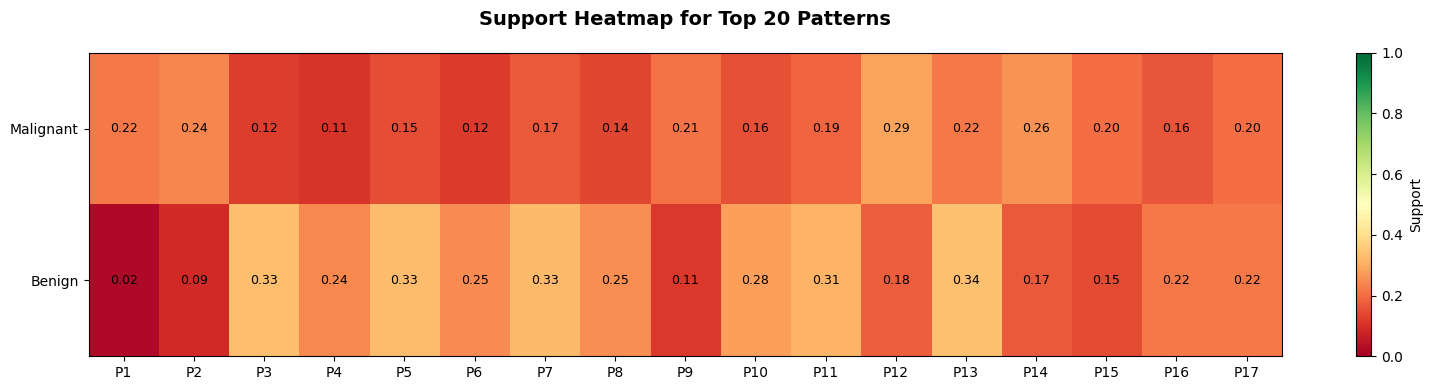

In [10]:
# Visualization 3: Heatmap of pattern support
top_20 = patterns.head(20)

# Create matrix for heatmap
support_matrix = top_20[['malignant_support', 'benign_support']].values.T
pattern_labels = [f"P{i+1}" for i in range(len(top_20))]

fig, ax = plt.subplots(figsize=(16, 4))
im = ax.imshow(support_matrix, cmap='RdYlGn', aspect='auto', vmin=0, vmax=1)

# Set ticks
ax.set_xticks(np.arange(len(pattern_labels)))
ax.set_yticks(np.arange(2))
ax.set_xticklabels(pattern_labels)
ax.set_yticklabels(['Malignant', 'Benign'])

# Add text annotations
for i in range(2):
    for j in range(len(pattern_labels)):
        text = ax.text(j, i, f'{support_matrix[i, j]:.2f}',
                      ha="center", va="center", color="black", fontsize=9)

ax.set_title('Support Heatmap for Top 20 Patterns', fontsize=14, fontweight='bold', pad=20)
plt.colorbar(im, ax=ax, label='Support')
plt.tight_layout()
plt.show()


Pattern Analysis by Length:
                     pattern   lift        malignant_support benign_support
                       count   mean    std              mean           mean
length discriminates                                                       
1      Benign              8  0.510  0.092             0.154          0.302
       Malignant           5  3.801  4.225             0.243          0.114
       Neutral             3  1.011  0.344             0.189          0.196
2      Benign              1  0.543    NaN             0.137          0.252


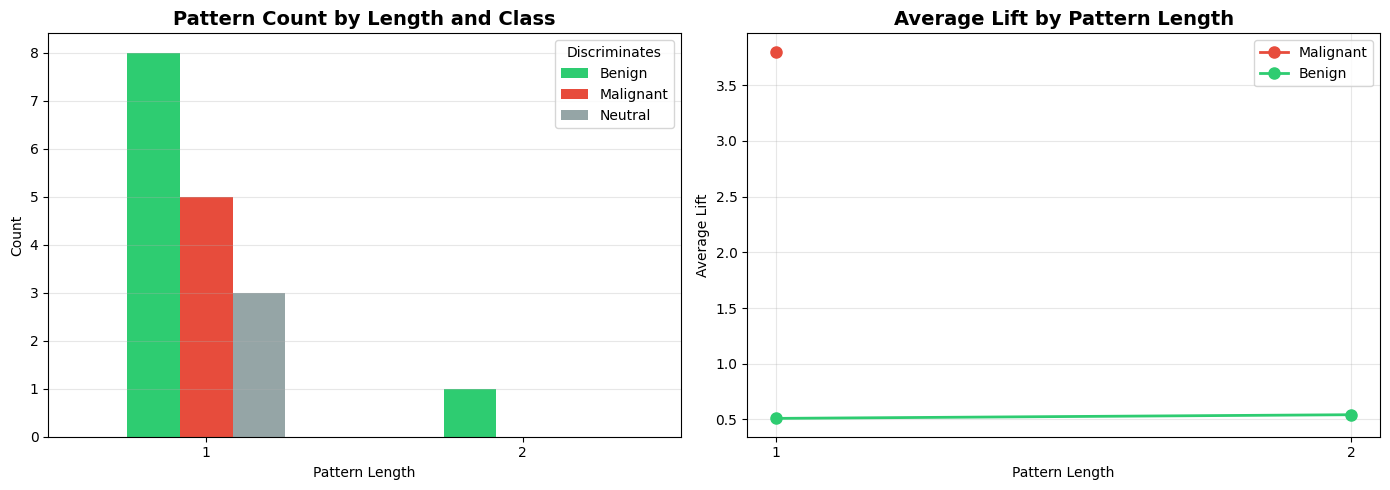

In [11]:
# Analyze patterns by length
length_analysis = patterns.groupby(['length', 'discriminates']).agg({
    'pattern': 'count',
    'lift': ['mean', 'std'],
    'malignant_support': 'mean',
    'benign_support': 'mean'
}).round(3)

print("\nPattern Analysis by Length:")
print("=" * 80)
print(length_analysis)

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Count by length and class
length_counts = patterns.groupby(['length', 'discriminates']).size().unstack(fill_value=0)
length_counts.plot(kind='bar', ax=axes[0], color=['#2ecc71', '#e74c3c', '#95a5a6'])
axes[0].set_title('Pattern Count by Length and Class', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Pattern Length')
axes[0].set_ylabel('Count')
axes[0].legend(title='Discriminates')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=0)
axes[0].grid(alpha=0.3, axis='y')

# Average lift by length
for disc_class, color in [('Malignant', '#e74c3c'), ('Benign', '#2ecc71')]:
    subset = patterns[patterns['discriminates'] == disc_class]
    avg_lift = subset.groupby('length')['lift'].mean()
    axes[1].plot(avg_lift.index, avg_lift.values, marker='o', 
                label=disc_class, color=color, linewidth=2, markersize=8)

axes[1].set_title('Average Lift by Pattern Length', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Pattern Length')
axes[1].set_ylabel('Average Lift')
axes[1].legend()
axes[1].grid(alpha=0.3)
axes[1].set_xticks(range(1, patterns['length'].max()+1))

plt.tight_layout()
plt.show()


In [12]:
# Export to CSV
from cancer_pattern_mining import export_results

export_results(patterns, sequences, output_prefix='cancer_mining_results')
print("\nResults exported successfully!")
print("Files created:")
print("  - cancer_mining_results_patterns.csv")
print("  - cancer_mining_results_sequences.csv")

Results exported to cancer_mining_results_patterns.csv and cancer_mining_results_sequences.csv

Results exported successfully!
Files created:
  - cancer_mining_results_patterns.csv
  - cancer_mining_results_sequences.csv


In [13]:
print("\n" + "=" * 80)
print("KEY FINDINGS SUMMARY")
print("=" * 80)

# Top malignant pattern
top_m = patterns[patterns['discriminates'] == 'Malignant'].iloc[0]
print(f"\n1. STRONGEST MALIGNANT PATTERN:")
print(f"   Pattern: {top_m['pattern_str']}")
print(f"   Lift: {top_m['lift']:.2f}")
print(f"   Malignant Support: {top_m['malignant_support']:.2%}")
print(f"   Benign Support: {top_m['benign_support']:.2%}")

# Top benign pattern
top_b = patterns[patterns['discriminates'] == 'Benign'].iloc[0]
print(f"\n2. STRONGEST BENIGN PATTERN:")
print(f"   Pattern: {top_b['pattern_str']}")
print(f"   Lift: {top_b['lift']:.2f}")
print(f"   Malignant Support: {top_b['malignant_support']:.2%}")
print(f"   Benign Support: {top_b['benign_support']:.2%}")

# Most common features
print(f"\n3. MOST DISCRIMINATIVE FEATURES:")
print(f"   Malignant: {', '.join(list(top_m_features.keys())[:5])}")
print(f"   Benign: {', '.join(list(top_b_features.keys())[:5])}")

# Pattern statistics
print(f"\n4. PATTERN STATISTICS:")
print(f"   Total patterns found: {len(patterns)}")
print(f"   Malignant-discriminative: {len(patterns[patterns['discriminates'] == 'Malignant'])}")
print(f"   Benign-discriminative: {len(patterns[patterns['discriminates'] == 'Benign'])}")
print(f"   Average pattern length: {patterns['length'].mean():.2f}")
print(f"   Most common length: {patterns['length'].mode()[0]}")

print("\n" + "=" * 80)



KEY FINDINGS SUMMARY

1. STRONGEST MALIGNANT PATTERN:
   Pattern: {area_mean}
   Lift: 11.31
   Malignant Support: 22.17%
   Benign Support: 1.96%

2. STRONGEST BENIGN PATTERN:
   Pattern: {texture_se}
   Lift: 0.37
   Malignant Support: 12.26%
   Benign Support: 33.33%

3. MOST DISCRIMINATIVE FEATURES:
   Malignant: area_mean, radius_worst, compactness_worst, radius_mean, fractal_dimension_worst
   Benign: texture_mean, texture_worst, texture_se, concave points_se, smoothness_mean

4. PATTERN STATISTICS:
   Total patterns found: 17
   Malignant-discriminative: 5
   Benign-discriminative: 9
   Average pattern length: 1.06
   Most common length: 1

